# Global indicator project - Phoenix, Arizona

## Create population analysis - set up studyregion adminitrative level population data (census block group in Phoenix)

This notebook describes the process to examine the census/administrative level population data supplied by the study region. This notebook examines block-group level data for Phoenix, Arizona, USA as an example. The population data are loaded and used to verify the GHSL population data source (250m grid-level population count).  

Process:
1. Load and plot county census block group data
2. Load and plot GHS population data for Greater Phoenix area (created in prior notebook)
3. Aggregate 250m grid-level population data up to block group level
    - aggregation method: select block groups overlap with population grid (block group with centroid within grids); then sum grid-level population up to block groups
4. Create population webmap


In [1]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import folium
import rasterio

from shapely.geometry import shape,Point, LineString, Polygon
from config import *

ox.config(use_cache=True, log_console=True)


## 1. Load and plot county census block group data

In [3]:
# check city administrative level
blockgroup = gpd.GeoDataFrame.from_file(admindata_filepath)
blockgroup.columns

Index(['TRACTCE10', 'BLOCKCE', 'BLOCKID10', 'HOUSING10', 'POP10', 'Sum_Employ',
       'geometry'],
      dtype='object')

In [4]:
def map_variable(df, col):
    values = df.dropna(subset=[col])
    ax = values.plot(column=col, scheme='quantiles', k=6, cmap='YlOrBr', figsize=(5,5))
    plt.show()

In [ ]:
map_variable(blockgroup, 'POP10')

## 2. Load and plot GHS population data

In [5]:
GHS_pop = gpd.GeoDataFrame.from_file(GHS_pop_filepath)
GHS_pop.head()

,raster_val,geometry
0,0.7044491171836853,POLYGON ((-112.7999591910156 34.00040467131404...
1,0.9279614090919495,POLYGON ((-112.7964752118525 34.00040467131404...
2,3.058992862701416,POLYGON ((-112.7895072535262 34.00040467131404...
3,1.3544756174087524,"POLYGON ((-112.786023274363 34.00040467131404,..."
4,1.1762453317642212,POLYGON ((-112.7825392951998 34.00040467131404...


In [6]:
# change to float type
GHS_pop['raster_val'] = GHS_pop['raster_val'].astype(float)

In [ ]:
map_variable(GHS_pop, 'raster_val')

In [ ]:
ax = blockgroup.plot(figsize=(10,10))
ax = GHS_pop.plot(ax=ax, column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', alpha=0.6)

plt.show()

## 3. Aggregate 250m grid-level population data up to block group level


### Select block level population within all GHSL population grid

In [ ]:
# select blocks (centroid) within the GHS built-up area
blockgroup_clip = blockgroup[blockgroup.centroid.within(GHS_pop.buffer(0.01).unary_union)]
len(blockgroup_clip)

In [ ]:
blockgroup_clip.plot()

In [ ]:
ox.save_gdf_shapefile(blockgroup_clip, filename='admin_urban_blockpop_{}'.format(placename), folder=pop_folder)

### Sum grid-level population up to block groups

In [4]:
GHS_pop = gpd.GeoDataFrame.from_file(GHS_pop_filepath)
GHS_pop['raster_val'] = GHS_pop['raster_val'].astype(float)
blockgroup_clip = gpd.GeoDataFrame.from_file('../data/Population/admin_urban_blockpop_{placename}/admin_urban_blockpop_{placename}.shp'.format(placename=placename))


# create null field for population values
blockgroup_clip['population'] = np.nan    
blockgroup_clip['population'].astype('Int64', inplace=True)
    
# associate analysis_area with aggregate population estimates
pop = 0
for row in range(1, len(blockgroup_clip)):
    area_id = blockgroup_clip[(row-1):row].index
    block_polygon = blockgroup_clip['geometry'].iloc[row]
    mask = GHS_pop.centroid.within(block_polygon)
    area_pop = float(np.sum(GHS_pop[mask]['raster_val']))
    blockgroup_clip.loc[area_id,'population'] = area_pop
               

In [5]:
ox.save_gdf_shapefile(blockgroup_clip, filename='GHS_2015Pop_250mgrid_block_{}'.format(placename), folder=pop_folder)

In [7]:
blockgroup_clip = gpd.GeoDataFrame.from_file('../data/Population/GHS_2015Pop_250mgrid_block_{placename}/GHS_2015Pop_250mgrid_block_{placename}.shp'.format(placename=placename))

In [ ]:
#make sure float type
for i in range(0, len(blockgroup_clip)):
    blockgroup_clip.loc[i, 'population'] = float(blockgroup_clip['population'][i])
    blockgroup_clip.loc[i, 'POP10'] = float(blockgroup_clip['POP10'][i])

In [42]:
blockgroup_clip.population.fillna(0, inplace=True)
blockgroup_clip.population = blockgroup_clip.population.astype(float)

In [46]:
blockgroup_clip.POP10 = blockgroup_clip.POP10.astype(int)

In [47]:
#sum of population comparison
blockgroup_clip.population.sum(), blockgroup_clip.POP10.sum()

(2094540.3534331596, 3815994)

/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/Users/NGAU/miniconda3/envs/asa/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 3
  Warn('Warning: setting k to %d' % k_q, UserWarning)


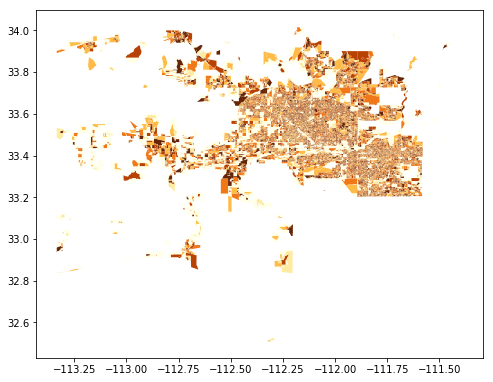

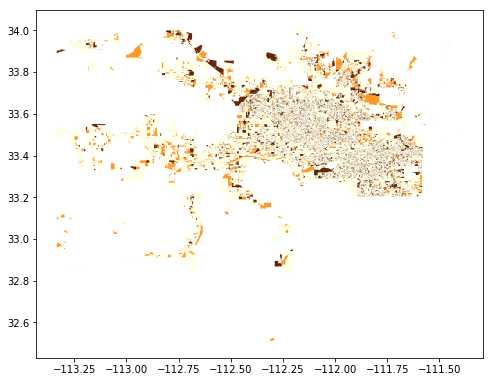

In [43]:
ax = blockgroup_clip.plot(column='POP10', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(8,8))
ax = blockgroup_clip.plot(column='population', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(8,8))

plt.show()

## 4. Create webmap

In [49]:
# reproject data layer and transfrom to geojson
to_crs = {'init': 'epsg:4326'} # ensure projection to lat-long

blockgroup_clip = gpd.GeoDataFrame.from_file('../data/Population/GHS_2015Pop_250mgrid_block_{placename}/GHS_2015Pop_250mgrid_block_{placename}.shp'.format(placename=placename))
blockgroup_clip = blockgroup_clip.to_crs(to_crs)
blockgroup_clip['POP10'] = blockgroup_clip['POP10'].astype(float).astype(int)
blockgroup_clip.population.fillna(0, inplace=True)
blockgroup_clip['population'] = blockgroup_clip['population'].astype(float).astype(int)
blockgroup_clip_json = blockgroup_clip.to_json()

# load study region boundary file and project to lat-long
clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)
clipping_boundary = clipping_boundary.to_crs(to_crs)

#load GHS population grid
GHS_pop = gpd.GeoDataFrame.from_file(GHS_pop_filepath)
GHS_pop = GHS_pop.to_crs(to_crs)
GHS_pop['raster_val'] = GHS_pop['raster_val'].astype(float).astype(int)
GHS_pop_json = GHS_pop.to_json()

In [50]:
# initialise map
centroid = GHS_pop.geometry.centroid

m = folium.Map(location=[centroid.y.mean(), centroid.x.mean()], zoom_start=9, tiles=None, control_scale=True, prefer_canvas=True)

m.add_tile_layer(tiles='OpenStreetMap', name='OpenStreetMap', overlay=True, active=True)

# add data as choropleth
buffer = folium.Choropleth(clipping_boundary.to_json(),
                           name = 'study region boundary',
                           fill_color = 'red',
                           fill_opacity = 0,
                           line_color = 'red', 
                           highlight = False).add_to(m)

c = folium.Choropleth(GHS_pop_json, data=GHS_pop['raster_val'], #bins=8,
                      columns=['raster_val'], 
                      key_on='feature.properties.raster_val', 
                      highlight=True, line_color='green', fill_color='GnBu',
                      fill_opacity=0.8, line_opacity=0.1,
                      legend_name='Population Count per pixel',
                      name='Population Count, 250m grid, Phoenix, AZ').add_to(m)

# add mouseover tooltip to the countries
c.geojson.add_child(folium.features.GeoJsonTooltip(['raster_val']))

b = folium.Choropleth(blockgroup_clip_json,  data=blockgroup_clip['POP10'], #bins=bins,
                      columns=['POP10'], 
                      key_on='feature.properties.POP10', 
                      highlight=True, fill_color='GnBu',
                      fill_opacity=0.8, line_color='blue', line_opacity=0.1,
                      legend_name='Population Count by blockgroup',
                      name='Population Count, Block level, Phoenix, AZ').add_to(m)

# add mouseover tooltip to the countries
b.geojson.add_child(folium.features.GeoJsonTooltip(['BLOCKID10', 'population', 'POP10'])) #county name and gdp when you add


folium.LayerControl().add_to(m)

# checkout https://nbviewer.jupyter.org/gist/jtbaker/57a37a14b90feeab7c67a687c398142c?flush_cache=true
# save map
map_name = '01_population_block.html'
m.save('../maps/{}'.format(map_name))
print("\nPlease inspect results using interactive map saved in project maps folder: {}\n".format(map_name)) 


Please inspect results using interactive map saved in project maps folder: 01_population_block.html

